# Spherical Descriptor Maps
Visualize per-pixel spherical descriptors: strength, anisotropy, azimuth/elevation, and dominant-axis azimuth.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from paperdrm import ImagePack, Settings
from paperdrm.drp_direction import (
    spherical_descriptor_maps,
    anisotropy_map_from_cov,
    plane_orientation_map_from_cov,
)

In [2]:
# Load images and DRP stack (adjust angle_slice if desired)
settings = Settings.from_yaml("exp_param.yaml").with_overrides(angle_slice=(1, 1), verbose=True)
images = ImagePack(settings=settings)

[ImagePack] Initialising ImagePack with data_root=e:\Code Repositories\PaperDRM\data folder=e:\Code Repositories\PaperDRM\data\processed
[ImagePack] Loading images (jpg) from e:\Code Repositories\PaperDRM\data\processed


loading images: 100%|██████████| 720/720 [00:01<00:00, 369.14it/s]


[ImagePack] Loaded 720 images; first image shape (2160, 4096)
[ImagePack] Subtracting backgrounds from e:\Code Repositories\PaperDRM\data\background


loading images: 100%|██████████| 720/720 [00:01<00:00, 711.12it/s]


[ImagePack] Preparing cache for angle_slice=(1, 1) stack_shape=(2160, 4096, 72, 10)
[ImagePack] Applied angle slice -> ph_num=72, th_num=10
[ImagePack] ImagePack initialisation complete


In [3]:
# Compute spherical descriptor maps
dir_map, proj_map, strength_map, m1_map, cov_map = spherical_descriptor_maps(
    images, subtract_mean=True, include_sin_theta=True,
    chunk_phi=8, chunk_theta=5, verbose=True
)
anisotropy = anisotropy_map_from_cov(cov_map)
mean, std = np.mean(anisotropy), np.std(anisotropy)
anisotropy = np.clip(anisotropy, mean-3*std, mean+3*std)
az_cov, el_cov = plane_orientation_map_from_cov(cov_map)


spherical_descriptor: streaming over DRP stack
spherical_descriptor: computing per-pixel mean
spherical_descriptor: accumulating first-order moment
spherical_descriptor: accumulating covariance
spherical_descriptor: done


In [4]:
anisotropy = np.clip(anisotropy, -5, 5)

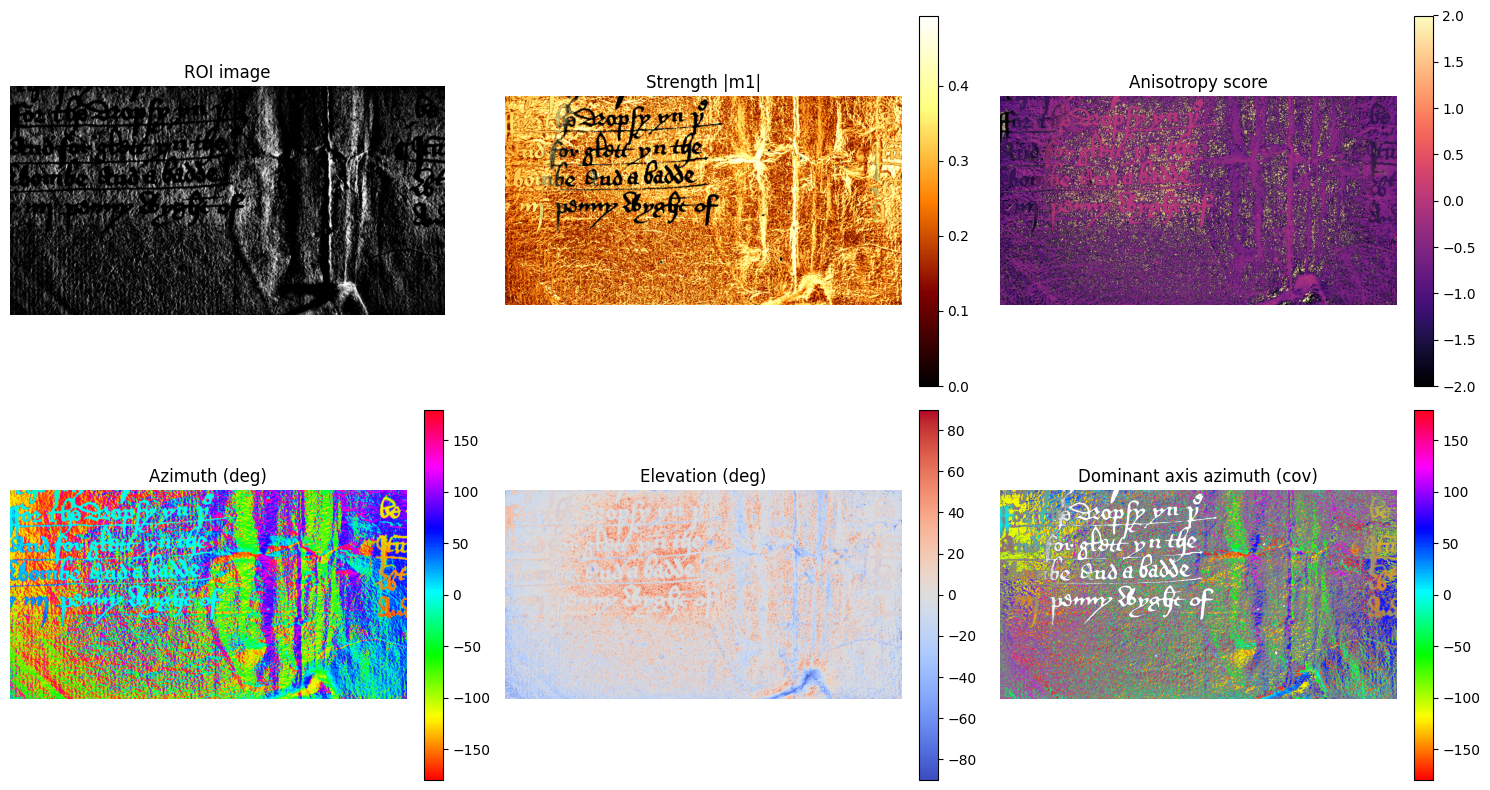

In [8]:
# Visualize strength, anisotropy, and orientations
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

axes[0, 0].imshow(images.images[0], cmap="gray")
axes[0, 0].set_title("ROI image")

im1 = axes[0, 1].imshow(strength_map, cmap="afmhot")
axes[0, 1].set_title("Strength |m1|")
fig.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

im2 = axes[0, 2].imshow(anisotropy, cmap="magma", vmin=-2, vmax=2)
axes[0, 2].set_title("Anisotropy score")
fig.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)

im3 = axes[1, 0].imshow(proj_map[..., 0], cmap="hsv")
axes[1, 0].set_title("Azimuth (deg)")
fig.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)

im4 = axes[1, 1].imshow(proj_map[..., 1], cmap="coolwarm")
axes[1, 1].set_title("Elevation (deg)")
fig.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)

im5 = axes[1, 2].imshow(az_cov, cmap="hsv")
axes[1, 2].set_title("Dominant axis azimuth (cov)")
fig.colorbar(im5, ax=axes[1, 2], fraction=0.046, pad=0.04)

for ax in axes.ravel():
    ax.axis("off")

plt.tight_layout()
plt.show()


In [6]:
evals, _ = np.linalg.eigh(0.5*(cov_map+np.swapaxes(cov_map,-1,-2)))
lam_sum = evals.sum(axis=-1)
print("lam_sum min/max:", lam_sum.min(), lam_sum.max())

lam_sum min/max: -0.9397116 0.14049332
